<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE8] - Variational AutoEncoder (VAE) with CelebA (small)
<!-- DESC --> Variational AutoEncoder (VAE) with CelebA (small res. 128x128)
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Build and train a VAE model with a large dataset in **small resolution(>70 GB)**
 - Understanding a more advanced programming model with **data generator**

The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) contains about 200,000 images (202599,218,178,3).  

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard

## Acknowledgements :
As before, thanks to **François Chollet** who is at the base of this example.  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from modules.callbacks      import ImagesCallback
from modules.data_generator import DataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from skimage import io

import os,sys,json,time,datetime
from IPython.display import display,Image,Markdown,HTML

from modules.VAE          import VAE, Sampling
from modules.loader_MNIST import Loader_MNIST
from modules.callbacks    import ImagesCallback, BestModelCallback

sys.path.append('..')
import fidle.pwk as pwk


run_dir = './run/CelebA-s.001'
datasets_dir = pwk.init('VAE8', run_dir)

**FIDLE 2020 - Practical Work Module**

Version              : 0.6.1 DEV
Notebook id          : VAE8
Run time             : Monday 4 January 2021, 18:43:15
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/datasets/fidle
Run dir              : ./run/CelebA-s.001
CI running mode      : none
Update keras cache   : False
Save figs            : True
Path figs            : ./run/CelebA-s.001/figs


## Step 2 - Prepare dataset
Let's instantiate our generator for the entire dataset.

### 1.2 - Directories and files :

In [2]:
# ---- Uncomment the right lines

# Tests
scale        = 0.3
image_size   = (128,128)
enhanced_dir = './data'

# Full clusters generation
# scale        = 1.
# image_size   = (192,160)
# enhanced_dir = f'{datasets_dir}/celeba/enhanced'

In [3]:
# ---- Used for continous integration - Just forget this 2 lines
#
image_size   = pwk.override('image_size',   image_size)
enhanced_dir = pwk.override('enhanced_dir', enhanced_dir)

# ---- the place of the clusters files
#
lx,ly      = image_size
train_dir  = f'{enhanced_dir}/clusters-{lx}x{ly}'
print('Train directory is :',train_dir)

Train directory is : ./data/clusters-128x128


In [4]:
data_gen = DataGenerator(train_dir, 32, k_size=scale)

print(f'Data generator : {len(data_gen)} batchs of {data_gen.batch_size} images, or {data_gen.dataset_size} images')

Data generator : 189 batchs of 32 images, or 6077 images


## Step 3 - Build model

In [5]:
latent_dim = 200

## Step 4 - Instanciate and compile model

#### Encoder

In [6]:
inputs    = keras.Input(shape=(lx, ly, 3))
x         = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)

shape_before_flattening = keras.backend.int_shape(x)[1:]

x         = layers.Flatten()(x)
x         = layers.Dense(512, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.compile()
# encoder.summary()

#### Decoder

In [7]:
inputs  = keras.Input(shape=(latent_dim,))

x = layers.Dense(np.prod(shape_before_flattening))(inputs)
x = layers.Reshape(shape_before_flattening)(x)

x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(3,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()
# decoder.summary()

#### VAE
Our loss function is the weighted sum of two values.  
`reconstruction_loss` which measures the loss during reconstruction.  
`kl_loss` which measures the dispersion.  

The weights are defined by: `r_loss_factor` :  
`total_loss = r_loss_factor*reconstruction_loss + (1-r_loss_factor)*kl_loss`

if `r_loss_factor = 1`, the loss function includes only `reconstruction_loss`  
if `r_loss_factor = 0`, the loss function includes only `kl_loss`  
In practice, a value of 0.3 gives good results here.


In [8]:
vae = VAE(encoder, decoder, image_size=(128,128), r_loss_factor=0.3)

vae.compile(optimizer=keras.optimizers.Adam())

Init VAE, with r_loss_factor=0.3 and image_size=(128, 128)


## Step 5 - Train
20' on a CPU  
1'12 on a GPU (V100, IDRIS)

In [9]:
x_draw,_   = data_gen[0]
data_gen.rewind()

# ---- Callback : Images encoded
pwk.mkdir(run_dir + '/images-encoded')
filename = run_dir + '/images-encoded/image-{epoch:03d}-{i:02d}.jpg'
callback_images1 = ImagesCallback(filename, x=x_draw[:5], encoder=encoder,decoder=decoder)

# ---- Callback : Images generated
pwk.mkdir(run_dir + '/images-generated')
filename = run_dir + '/images-generated/image-{epoch:03d}-{i:02d}.jpg'
callback_images2 = ImagesCallback(filename, x=None, nb_images=5, z_dim=latent_dim, encoder=encoder,decoder=decoder)          

# ---- Callback : Best model
pwk.mkdir(run_dir + '/models')
filename = run_dir + '/models/best_model'
callback_bestmodel = BestModelCallback(filename)

# ---- Callback tensorboard
dirname = run_dir + '/logs'
callback_tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

callbacks_list = [callback_images1, callback_images2, callback_bestmodel, callback_tensorboard]

In [10]:
%%time

batch_size = 64
epochs     = 10

history = vae.fit(data_gen, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list,
          initial_epoch     = 0)


Epoch 1/10
189/189 [==============================] - 66s 350ms/step - loss: 2965.3139 - reconstruction_loss: 9880.6431 - kl_loss: 1.6012    (saved)   
Epoch 2/10
189/189 [==============================] - 74s 390ms/step - loss: 2635.2734 - reconstruction_loss: 8777.8746 - kl_loss: 2.7298
Epoch 3/10
189/189 [==============================] - 74s 394ms/step - loss: 2585.2522 - reconstruction_loss: 8610.6610 - kl_loss: 2.9340    (saved)   
Epoch 4/10
189/189 [==============================] - 75s 396ms/step - loss: 2548.4100 - reconstruction_loss: 8487.3168 - kl_loss: 3.1641
Epoch 5/10
189/189 [==============================] - 78s 410ms/step - loss: 2515.3460 - reconstruction_loss: 8376.8219 - kl_loss: 3.2848    (saved)   
Epoch 6/10
189/189 [==============================] - 77s 408ms/step - loss: 2501.3582 - reconstruction_loss: 8330.0091 - kl_loss: 3.3649    (saved)   
Epoch 7/10
189/189 [==============================] - 77s 405ms/step - loss: 2487.7237 - reconstruction_loss: 8284.4

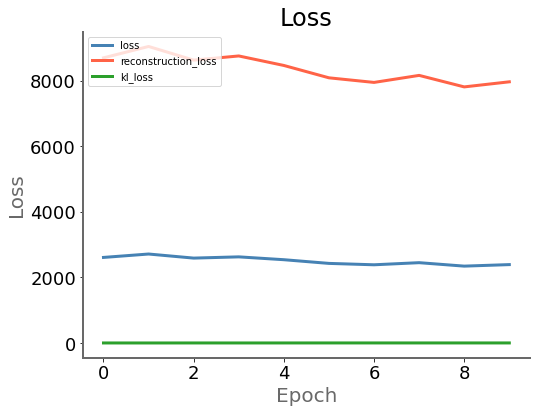

In [11]:
pwk.plot_history(history,  plot={"Loss":['loss','reconstruction_loss', 'kl_loss']}, save_as='history')

## Step 7 - Learning progression (encoded/decoded)

<br>**Original images :**

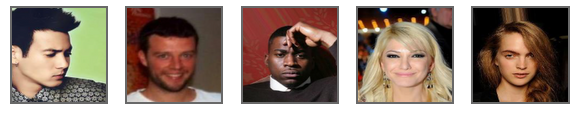

<br>**Encoded/decoded images**

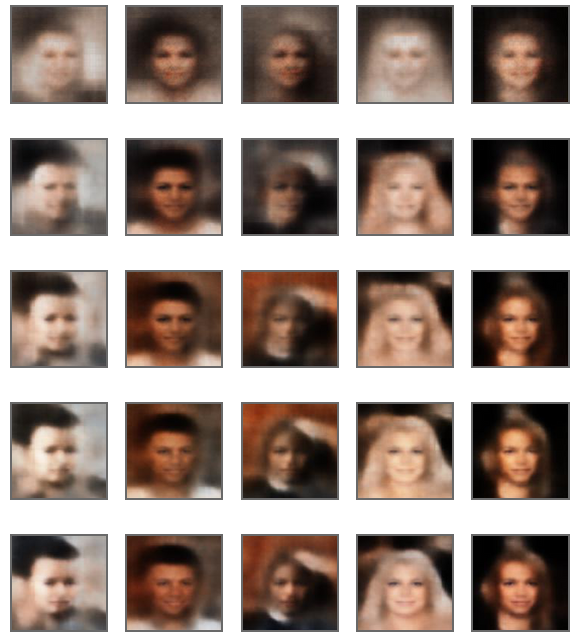

<br>**Original images :**

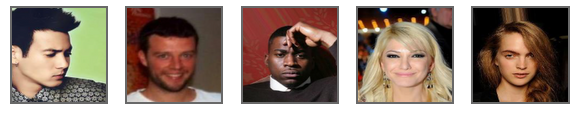

In [12]:
imgs=[]
labels=[]
for epoch in range(0,epochs,2):
    for i in range(5):
        filename = f'{run_dir}/images-encoded/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        

pwk.subtitle('Original images :')
pwk.plot_images(x_draw[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)

pwk.subtitle('Encoded/decoded images')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, save_as='02-reconstruct')

pwk.subtitle('Original images :')
pwk.plot_images(x_draw[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)


## Step 8 - Learning progression (Generated)

<br>**Generated images from latent space**

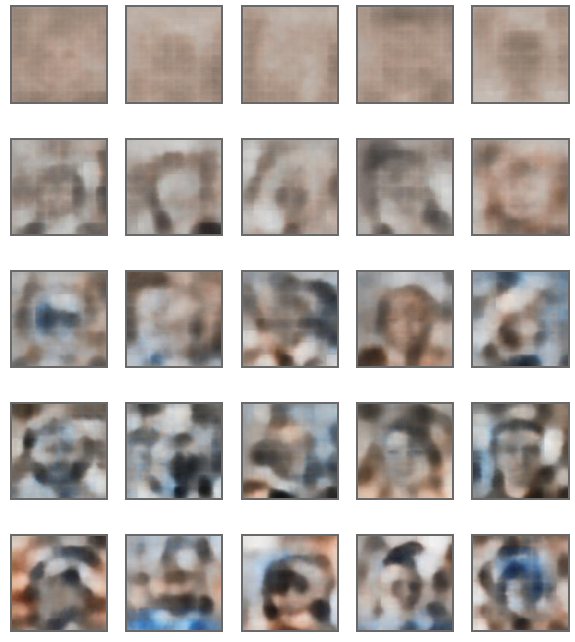

In [13]:
imgs=[]
labels=[]
for epoch in range(0,epochs,2):
    for i in range(5):
        filename = f'{run_dir}/images-generated/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        
pwk.subtitle('Generated images from latent space')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, save_as='03-encoded')


In [14]:
pwk.end()

End time is : Monday 4 January 2021, 18:56:01
Duration is : 00:12:46 153ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>